In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import warnings
import seaborn as sns
from collections import Counter
from Helpers.radiomics_setup import RadiomicsClean, MultiParamProcessor

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
warnings.simplefilter(action='ignore', category=Warning)


Imported 0.3.2 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False, skip_xgboost=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



In [ ]:
path_to_csv = r"Data\UC2_retrospective\ProCancer_UC2_N4_ADC_DL_PZ_radio.csv"
problematic = r"D:\dimza\EXPERIMENTS\ProstateCancerClinicalSignificance_UC2\UC2_prospective_and_retrospective\Borderline_cases_to_remove.csv"
jenn = r"Data\data_characteristics.csv"

exl = ["study_uid",
"number_of_series",
"provided_by",
"manufacturer",
"manufacturer_model_name",
"pi_rads"]

rdc = RadiomicsClean(path_to_csv)
rdc.clean_borderlines(problematic)
rdc.drop_columns_from_df(excluded_columns = exl)
#rdc.create_target()
rdc.create_target_based_on_csv(target_csv=jenn)
rdc.keep_zone_location(zone="PZ")
rdc.add_suffix("T2")
features = rdc.get_processed()

In [2]:
csv_paths = [
    r"Data\UC2_retrospective\ProCancer_UC2_N4_T2_DL_PZ_radio.csv",
    r"Data\UC2_retrospective\ProCancer_UC2_N4_ADC_DL_PZ_radio.csv",
    r"Data\UC2_retrospective\ProCancer_UC2_N4_DWI_DL_PZ_radio.csv",
]

exl = ["study_uid",
"number_of_series",
"provided_by",
"manufacturer",
"manufacturer_model_name",
"pi_rads"]

problematic = r"D:\dimza\EXPERIMENTS\ProstateCancerClinicalSignificance_UC2\UC2_prospective_and_retrospective\Borderline_cases_to_remove.csv"
jenn = r"Data\data_characteristics.csv"

mpp = MultiParamProcessor(
    csv_paths = csv_paths,
    problematic = problematic
)
mpp.iteration(
    suffices=["T2", "ADC", "DWI"],
    columns_to_exclude= exl,
    target_csv=jenn
)

dfs = mpp.get_dfs()

In [3]:
retro = pd.concat([dfs[0], dfs[1], dfs[2]], axis = 1)
X = retro.drop('Target', axis=1)  # Drop the 'Target' column for X_train
y = retro['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
from Helpers import pipelines
from Helpers import behave_metrics
from Helpers import shap_module

In [5]:
lr_hyperparameters = {'C': 1.0, 'penalty': 'l2'}
svm_hyperparameters = {'C': 1.0, 'kernel': 'rbf', 'probability':True}
xgb_hyperparameters = {'n_estimators': 100}
ada_hyperparameters = {'n_estimators': 50}
rf_hyperparameters = {'n_estimators': 100}
dt_hyperparameters = {'criterion': 'gini'}

names = ["Logistic Regression", "SVM", "Random Forest", "AdaBoost", "Decision trees", "XGBoost"]
classifiers = [LogisticRegression, SVC, RandomForestClassifier, AdaBoostClassifier, DecisionTreeClassifier, XGBClassifier]
hypers = [lr_hyperparameters , svm_hyperparameters, rf_hyperparameters, ada_hyperparameters, dt_hyperparameters, xgb_hyperparameters]

In [ ]:
lr_hyperparameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': [None, 'l2'],
    'solver': ['lbfgs','liblinear', 'saga','newton-cholesky'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced'],
}

svm_hyperparameters = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto'],
    'probability':[True],
}

rf_hyperparameters = {
    'n_estimators': [2,4,6,10,20,50],
    'max_depth': [1,2,4,6,8, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

ada_hyperparameters = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    "n_jobs":[-1]
}

dt_hyperparameters = {
    'max_depth': [2,5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

xgb_hyperparameters = {
    'n_estimators': [3,5,10, 50],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [1,2, 3, 6, 10, 20],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
}
hypers = [lr_hyperparameters , svm_hyperparameters, rf_hyperparameters, ada_hyperparameters, dt_hyperparameters, xgb_hyperparameters]

In [6]:
pipeline_dict ={}
for cls, hp, nm in zip(classifiers, hypers, names):
    pipeline = pipelines.MLPipeline(X_train, y_train, cls, hp)
    pipeline.execute_feature_selection(corr_limit=0.6)
    pipeline.execute_preprocessing()
    pipeline.train_model(perform_grid_search=False, param_grid=hp, cv=5)
    pipeline_dict.update({nm:pipeline})

featurewiz has selected 0.6 as the correlation limit. Change this limit to fit your needs...
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Binary_Classification problem ####
    Loaded train data. Shape = (2924, 3739)
    Some column names had special characters which were removed...
#### Single_Label Binary_Classification problem ####
No test data filename given...
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
        No variables were removed since no ID or low-information variables found in data set
Removing 0 columns from further processing since ID or low information variables
#####################################################################################

In [ ]:
pipelines = [pipeline]

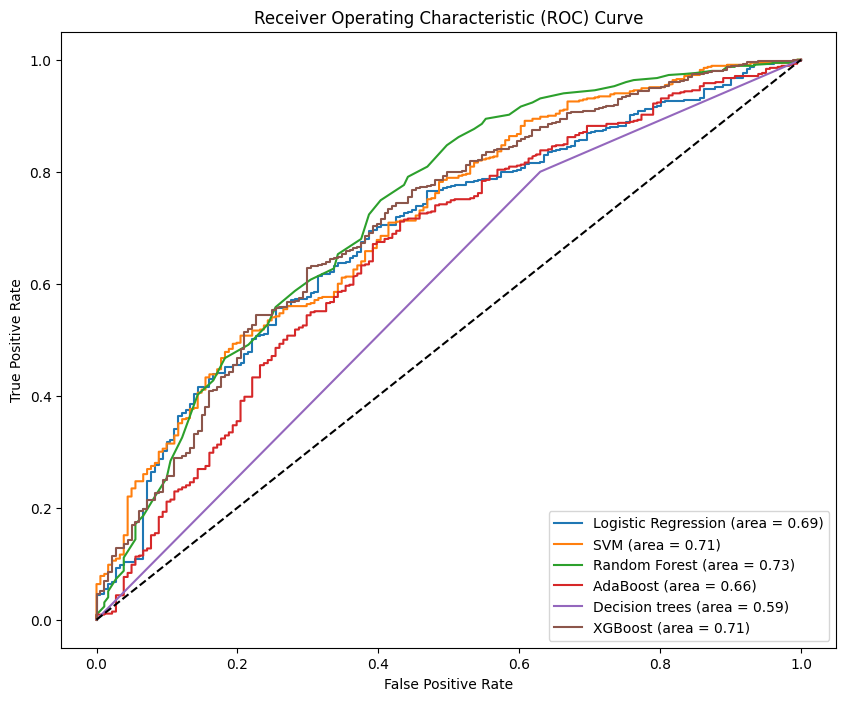

In [7]:
roc = behave_metrics.ROCCurveEvaluator(pipeline_dict,X_test=X_test, y_true=y_test)
roc.evaluate_models()
roc.plot_roc_curves()

In [35]:

import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, is_classifier

class ShapAnalysis:
    def __init__(self, X_train: np.array, X_val: np.array, model: BaseEstimator, features: list) -> None:
        self.xtr = X_train
        self.xvl = X_val
        self.explainer = None
        self.model = model
        self.features = features
    
    def perform_shap(self):
        sample_size = int(0.5 * len(self.xvl))
        sampled_data = shap.sample(self.xvl, sample_size)
        print(f"Sample size: {sample_size}, Sampled data shape: {sampled_data.shape}")
        
        if isinstance(self.model, (XGBClassifier, RandomForestClassifier, DecisionTreeClassifier, AdaBoostClassifier)):
            self.explainer = shap.TreeExplainer(self.model)
        else:
            self.explainer = shap.KernelExplainer(self.model.predict_proba, sampled_data)
        
        shap_values = self.explainer.shap_values(self.xvl)
        print(f"SHAP values shape: {np.array(shap_values).shape}")
        return shap_values
    
    def plot_shap_values(self, model_name: str, path: str):
        plt.clf()
        shap_values = self.explainer.shap_values(self.xvl)
        print(f"SHAP values for plotting shape: {np.array(shap_values).shape}")
        
        if isinstance(shap_values, list):
            # Assuming binary classification and interested in SHAP values for class 1
            values_to_plot = shap_values[1]
        else:
            # For regression or binary classification models where a single array is returned
            values_to_plot = shap_values
        
        shap.summary_plot(values_to_plot, self.xvl, feature_names=self.features, show=False)
        
        if path:
            plot_path = os.path.join(path, model_name + "_ShapFeatures.png")
        else:
            plot_path = model_name + "_ShapFeatures.png"
        plt.savefig(plot_path, dpi=400, bbox_inches='tight')
        plt.close()

In [36]:

me = behave_metrics.ModelEvaluator(pipeline_dict["Random Forest"],X_test)
me.evaluate()["y_test"][:, 1]

sp = ShapAnalysis(pipeline.X_train, me.X_test_transformed, model = pipeline.best_model, features=pipeline.selected_features) 
shap_values,features = sp.perform_shap(), pipeline.selected_features
sp.plot_shap_values(model_name=nm, path=r"./")

AttributeError: 'ShapAnalysis' object has no attribute 'X_val'

In [28]:
shap_values.shape

(731, 417)

In [ ]:
csv_paths = [
    r"Data\UC2_prospespective\ProCancer_UC2_N4_T2_DL_PZ_radio.csv",
    r"Data\UC2_prospespective\ProCancer_UC2_N4_ADC_DL_PZ_radio.csv",
    r"Data\UC2_prospespective\ProCancer_UC2_N4_DWI_DL_PZ_radio.csv",
]

mpp = MultiParamProcessor(
    csv_paths = csv_paths,
    problematic = problematic
)
mpp.iteration(
    suffices=["T2", "ADC", "DWI"],
    columns_to_exclude= exl
)

dfs = mpp.get_dfs()
prospe = pd.concat([dfs[0], dfs[1], dfs[2]], axis = 1)
X_test = prospe.drop('Target', axis=1)  # Drop the 'Target' column for X_train
y_test = prospe['Target']

evaluator = ModelEvaluator(pipeline, X_test)

# Evaluate the model on validation and test datasets
evaluation_results = evaluator.evaluate()

In [ ]:
evaluation_results

In [ ]:
clfs = {}
proportion_to_undersample = 0.3
user_features = {}
for cls, hp, nm in zip(classifiers, hypers, names):
    peruser = {}
    for sr in features["user"].unique():
        if nm == "Logistic Regression":
            #features_under = undersample(features,sr, proportion= proportion_to_undersample)
            #features_under.drop(columns="os user", inplace=True)
            X_train, X_val, X_test, y_train, y_val, y_test = splits(features, sr)


            pipeline = pipelines.MLPipeline(X_train, y_train, cls, hp)
            pipeline.execute_feature_selection()
            pipeline.execute_preprocessing() 
            pipeline.train_model(perform_grid_search=False, param_grid=hp, cv=2)  # or True with param_grid

            # Initialize ModelEvaluator with validation and test data
            evaluator = pipelines.ModelEvaluator(pipeline, X_val, X_test)

            # Evaluate the model on validation and test datasets
            evaluation_results = evaluator.evaluate()
            # Initialize the finder
            threshold_finder = behave_metrics.ThresholdOptimizer(pipeline, evaluator.X_val_transformed, y_val, evaluator.X_test_transformed, y_test)

            # Find the optimal threshold
            optimal_threshold = threshold_finder.find_optimal_threshold()
            print(f"Optimal Threshold: {optimal_threshold}")

            # Apply the optimal threshold on test data and get the evaluation
            test_evaluation = threshold_finder.apply_optimal_threshold()
            #mlflow.log_params(replaced_featurewiz)

            sp = shap_module.ShapAnalysis(pipeline.X_train, evaluator.X_val_transformed, model = pipeline.best_model, features=pipeline.selected_features) 
            shap_values,features = sp.perform_shap(), pipeline.selected_features
            sp.plot_shap_values(model_name=nm+"_"+sr, path=r"C:\Users\dimza\Desktop\Quadible\Technical\temp_delete_shap")

            metr = behave_metrics.metrics(test_evaluation, y_test.values)
            metr.perf_measure()
            metr.FAR()
            metr.FRR()
            peruser.update({sr:metr.balanced()})
            clfs.update({nm:peruser})

In [ ]:
shap_values[1].max()

In [ ]:
def calculate_mean_metrics(metrics_dict):
    total_FAR = total_FRR = total_Balanced = 0
    count = 0

    for key, values in metrics_dict.items():
        for sub_key, metrics in values.items():
            total_FAR += metrics['FAR']
            total_FRR += metrics['FRR']
            total_Balanced += metrics['Balanced']
            count += 1

    mean_FAR = total_FAR / count if count else 0
    mean_FRR = total_FRR / count if count else 0
    mean_Balanced = total_Balanced / count if count else 0

    return {"Mean_FAR": mean_FAR, "Mean_FRR": mean_FRR, "Mean_Balanced": mean_Balanced}

calculate_mean_metrics(clfs)

In [ ]:
clfs

In [ ]:
hp_grid = {'Mean_FAR': 0.2674692499111269,
 'Mean_FRR': 0.39666666666666667,
 'Mean_Balanced': 0.3320679582888968}